# Generate the Ground Truth Overlap
The file to generate ground truth overlaps which used in training and validation.


In [1]:
import os
import yaml
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from normalize_data import normalize_data
from tools.fileloader import load_xyz_rot

# auto-reload external modules
%load_ext autoreload
%autoreload 2


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load Configuration
Modify the configuration in *config/gen_gt_overlap.yml*.

In [9]:
# # load config file
# config_filename = '../config/gen_gt_overlap_pcd.yml'
# lidar_params_path = '/home/vectr/PycharmProjects/Overlaps_Training_Data_Generator/lidar.json'
# 
# # add sequence label to the data and save them as npz files
# seq_idx = 'royce_hall'
# # load the configuration file
# config = yaml.safe_load(open(config_filename))
# lidar_params = Params(lidar_params_path).dict
# 
# # set the related paths
# poses_file = config[seq_idx]['poses_file']
# scan_folder = config[seq_idx]['scan_folder']
# dst_folder = config[seq_idx]['dst_folder']
# npy_folder = config[seq_idx]['npy_folder']  # optional, to increase the computation speed

# config_path = '/home/vectr/PycharmProjects/lidar_learning/configs/config.yml'
config_path = '/Users/yanlong/PycharmProjects/lidar_learning/configs/config.yml'
# parameters_path = '/home/vectr/PycharmProjects/lidar_learning/configs/parameters.yml'
parameters_path = '/Users/yanlong/PycharmProjects/lidar_learning/configs/parameters.yml'

config = yaml.safe_load(open(config_path))
parameters = yaml.safe_load(open(parameters_path))

overlaps_folder = config['data_root']['overlaps']
poses_folder_path = config['data_root']['poses']
gt_overlaps_folder = config['data_root']['gt_overlaps']
lidar_params = parameters['lidar']

seq = config['seqs']['all'][1]


## Generate Overlap and Yaw Ground Truth Array

In [11]:
# load overlap matrix
overlaps_matrix_path = os.path.join(overlaps_folder, f'{seq}.bin')
overlaps_matrix = np.fromfile(overlaps_matrix_path)
overlaps_matrix = overlaps_matrix.reshape(-1, int(np.sqrt(overlaps_matrix.shape)))
print(f'Matrix shape: {overlaps_matrix.shape}')

# poses_path = os.path.join(poses_folder_path, seq, 'poses.txt')
poses_path = '/Users/yanlong/Desktop/overlaps/poses.txt'
xyz, rot = load_xyz_rot(poses_path)
print(f'Number of positions: {xyz.shape}.')

Matrix shape: (3910, 3910)
Number of positions: (3910, 3).


In [46]:
# plt.scatter(xyz[:, 0], xyz[:, 1])
# plt.show()
overlap_thresh = 0.5

%matplotlib qt
num_scans = xyz.shape[0]
for i in range(num_scans):
    overlaps_i = overlaps_matrix[i, :]
    xyz_pos_i = xyz[overlaps_i > overlap_thresh, :]

    plt.scatter(xyz[:, 0], xyz[:, 1], c='b')
    plt.scatter(xyz_pos_i[:, 0], xyz_pos_i[:, 1], c='y')
    plt.scatter(xyz[i, 0], xyz[i, 1], c='g')
    plt.show()
    plt.pause(0.0001)
    plt.clf()

## Histogram of Overlaps Distribution
Plot the histogram which is used to normalize the dataset.

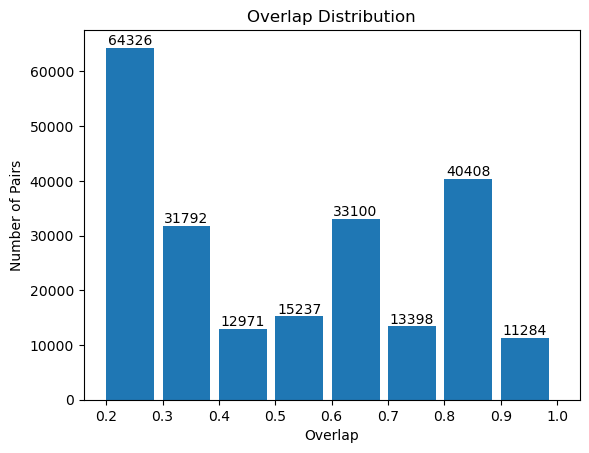

In [82]:
# only show tail bins
min_overlap_show = 0.2
max_overlap_show = 1.0
overlaps = ground_truth_mapping[:,2]

_, _, patches = plt.hist(overlaps[(overlaps <= max_overlap_show) & (overlaps >= min_overlap_show)], int((max_overlap_show-min_overlap_show)/0.1), width=0.085)
plt.bar_label(patches)
plt.title('Overlap Distribution')
plt.xlabel('Overlap')
plt.ylabel('Number of Pairs')
plt.show()

## Normalize Overlaps Distribution
We need balance the number of positive and negative data pairs for training. Based on the ***Histogram*** above, select a threshold (0.5 by default) to reduce the number of negative data pairs. Moreover, we can control the number of pairs to adjust the training time.

100%|██████████| 4628/4628 [00:02<00:00, 1920.72it/s]


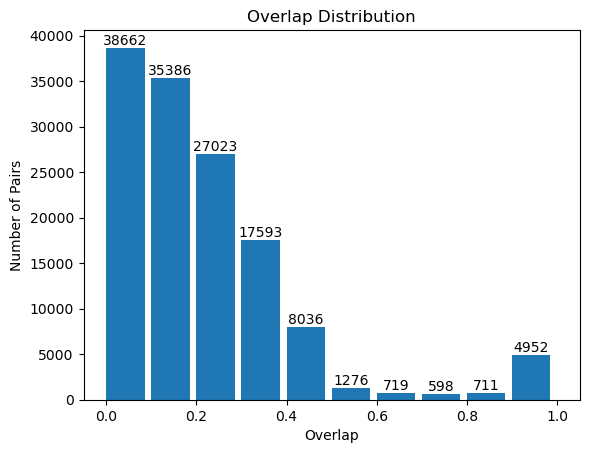

dist_norm_data shape: (134956, 4)
Number of positive pairs: 60908.
Number of negative pairs: 74048.
Select 0.63% data
Average 13.16076058772688 positive data per frame
Average 16.0 negative data per frame


In [83]:
neg_pos_threshold = 3

dist_norm_data = normalize_data(ground_truth_mapping, max_pos_thresh=16, min_neg_thresh=8, neg_pos_threshold=neg_pos_threshold)
overlaps_norm = dist_norm_data[:,2]
_, _, patches = plt.hist(overlaps_norm, 10, width=0.085)
plt.bar_label(patches)
plt.title('Overlap Distribution')
plt.xlabel('Overlap')
plt.ylabel('Number of Pairs')
plt.show()

percent_keep = format(len(dist_norm_data) / len(ground_truth_mapping) * 100, ".2f")
num_pos = np.sum(overlaps_norm >= neg_pos_threshold / 10)
num_neg = np.sum(overlaps_norm < neg_pos_threshold / 10)

print(f"dist_norm_data shape: {dist_norm_data.shape}")
print(f"Number of positive pairs: {num_pos}.")
print(f"Number of negative pairs: {num_neg}.")
print(f"Select {percent_keep}% data")
print(f"Average {num_pos / np.sqrt(len(ground_truth_mapping))} positive data per frame")
print(f"Average {num_neg / np.sqrt(len(ground_truth_mapping))} negative data per frame")


## Generate Training and Validation Dataset
Split the dataset to training and validation sets.

In [84]:
from sklearn.model_selection import train_test_split
# split ground truth for training and validation
train_data, validation_data = split_train_val(dist_norm_data)

# specify the goal folder
# dst_folder = os.path.join(dst_folder, 'ground_truth')
try:
    os.stat(dst_folder)
    print('generating depth data in: ', dst_folder)
except:
    os.mkdir(dst_folder)
    print('creating new depth folder: ', dst_folder)

# training data
train_seq = np.empty((train_data.shape[0], 2), dtype=object)
train_seq[:] = seq_idx
np.savez_compressed(dst_folder + f'/train_set', overlaps=train_data, seq=train_seq)

# validation data
validation_seq = np.empty((validation_data.shape[0], 2), dtype=object)
validation_seq[:] = seq_idx
np.savez_compressed(dst_folder + f'/validation_set', overlaps=validation_data, seq=validation_seq)

# raw ground truth data, fully mapping, could be used for testing
ground_truth_seq = np.empty((ground_truth_mapping.shape[0], 2), dtype=object)
ground_truth_seq[:] = seq_idx
np.savez_compressed(dst_folder + '/ground_truth_overlap_yaw', overlaps=ground_truth_mapping, seq=ground_truth_seq)

# normalized ground truth data
dist_norm_data_seq = np.empty((dist_norm_data.shape[0], 2), dtype=object)
dist_norm_data_seq[:] = seq_idx
np.savez_compressed(dst_folder + '/dist_norm_set', overlaps=dist_norm_data, seq=dist_norm_data_seq)

print(f'Finish saving the ground truth data for training and testing at: {os.path.abspath(dst_folder)} \n')

print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {validation_data.shape}")
print(f'Distribution Norm set shape: {dist_norm_data.shape}')


generating depth data in:  /media/vectr/T7/Dataset/overlap_transformer/gt_overlap/royce_hall
Finish saving the ground truth data for training and testing at: /media/vectr/T7/Dataset/overlap_transformer/gt_overlap/royce_hall 

Training set shape: (121460, 4)
Validation set shape: (13496, 4)
Distribution Norm set shape: (134956, 4)


## Visualize Generate Dataset (Option)
Visualize the generated overlaps for a frame.

In [41]:
# load map
xy_pos = poses[:, :2, 3]

# select one frame and its overlap pairs
num_seq = len(xy_pos)
num_pairs = len(ground_truth_mapping)
num_frames = num_pairs // num_seq
frame_idx = np.random.choice(num_frames,1)[0]

# whole map for frame idx
ground_truth_mapping_idx = ground_truth_mapping[frame_idx*num_seq:(frame_idx+1)*num_seq, :]

# # normalize map for frame idx.
# dist_norm_pose_idx = np.empty((0, 2))
# dist_norm_data_idx = np.empty((0, 4))
# 
# for i in range(len(dist_norm_data)):
#     if int(dist_norm_data[i, 0]) == frame_idx:
#         reference_idx = int(dist_norm_data[i, 1])
#         dist_norm_pose_idx = np.append(dist_norm_pose_idx, poses[reference_idx,:2,3].reshape(1,2), axis=0)
#         dist_norm_data_idx = np.append(dist_norm_data_idx, dist_norm_data[i,:].reshape(1,4), axis=0)

counter_norm = 0
counter_max = 0
for frame_idx in tqdm.tqdm(range(num_frames)):
    dist_norm_pose_idx = np.empty((0, 2))
    dist_norm_data_idx = np.empty((0, 4))
    for i in range(len(dist_norm_data)):
        if int(dist_norm_data[i, 0]) == frame_idx:
            reference_idx = int(dist_norm_data[i, 1])
            dist_norm_pose_idx = np.append(dist_norm_pose_idx, poses[reference_idx,:2,3].reshape(1,2), axis=0)
            dist_norm_data_idx = np.append(dist_norm_data_idx, dist_norm_data[i,:].reshape(1,4), axis=0)

    if np.sum(dist_norm_data_idx[:,2] >= 0.3) < 6:
        counter_norm += 1

    ground_truth_mapping_current_frame = ground_truth_mapping[frame_idx*num_frames:(frame_idx+1)*num_frames, :]
    if np.sum(ground_truth_mapping_current_frame[:,2] >= 0.3) < 6:
        counter_max += 1

print(f'{counter_norm / num_frames * 100}% data has positive pairs less than 6.')
print(f'{counter_max / num_frames * 100}% data has positive pairs less than 6 maximal.')
        
# print(f'Frame: {frame_idx}.')
# print(f'Number of pairs: {len(dist_norm_pose_idx)}')
# print(f'Number of positive pairs : {np.sum(dist_norm_data_idx[:,2] >= 0.3)}')
# print(f'Number of negative pairs : {np.sum(dist_norm_data_idx[:,2] < 0.3)}')
# 
# vis_gt(xy_pos, ground_truth_mapping_idx)
# vis_gt(dist_norm_pose_idx, dist_norm_data_idx)


100%|██████████| 3945/3945 [01:24<00:00, 46.44it/s]

3.3460076045627374% data has positive pairs less than 6.
3.3460076045627374% data has positive pairs less than 6 maximal.
